In [5]:
import pandas as pd

# ============================================================
# 1) CARGAR DATASET BASE V2.1
# ============================================================

df = pd.read_csv("../data/clean/dataset_base_v21.csv")
print("Dataset cargado:", df.shape)
df.head()


# ============================================================
# 2) CARGAR WHITELISTS OFICIALES (CORREGIDAS)
# ============================================================

# Dominios españoles → columna 'domain' (columna 1)
esp = pd.read_csv("../docs/dominios_espanyoles.csv", usecols=[1], header=0)\
        ["domain"].str.lower().str.strip()

print("Dominios españoles reales:", len(esp))

# Dominios globales legítimos
glob = pd.read_csv("../docs/global_neutral_domains.csv", header=None)[0]\
         .str.lower().str.strip()

print("Dominios globales neutrales:", len(glob))


# ============================================================
# 3) CREAR WHITELIST COMBINADA (SOLO DOMINIOS VÁLIDOS)
# ============================================================

# Combinar listas
whitelist = set(esp).union(set(glob))

# Filtrar solo dominios válidos (deben contener un '.')
whitelist = {d for d in whitelist if "." in d}

print("Whitelist final (válida):", len(whitelist))

# Vista previa
list(whitelist)[:20]


Dataset cargado: (492, 31)
Dominios españoles reales: 200
Dominios globales neutrales: 77
Whitelist final (válida): 276


['serviciodecorreo.es',
 'mi-dominio.es',
 'gva.es',
 'vodafone.es',
 'airbnb.es',
 'sport.es',
 'loteriasyapuestas.es',
 'alsa.es',
 'monster.es',
 'boe.es',
 'zalando.es',
 'haystack.es',
 'lidl.es',
 'esy.es',
 'jcyl.es',
 'larazon.es',
 'carm.es',
 'diariodemallorca.es',
 'agenciatributaria.gob.es',
 'ebay.es']

In [6]:
import tldextract
from urllib.parse import urlparse
from collections import Counter
from math import log2

# ============================================================
# Función auxiliar: entropía de Shannon
# ============================================================
def shannon_entropy(text):
    if not text:
        return 0.0
    freqs = Counter(text)
    length = len(text)
    return -sum((c/length) * log2(c/length) for c in freqs.values())


# ============================================================
# domain_complexity v2.3 (POC)
# ============================================================
def domain_complexity_v23(url, whitelist):

    # Parseo
    ext = tldextract.extract(url)
    registered = (ext.registered_domain or "").lower()
    core = (ext.domain or "").lower()

    # Caso degenerado
    if not registered:
        return 0.0

    # Señales base
    domain_length = len(registered)
    domain_entropy = shannon_entropy(core)

    # Normalización
    norm_len = min(domain_length / 18.0, 1.0)
    norm_ent = min(domain_entropy / 3.8, 1.0)

    # Combinación
    raw = 0.78 * norm_ent + 0.22 * norm_len

    # Penalización dominios cortos
    if domain_length < 10:
        raw *= 0.35

    # Whitelist dura
    if registered in whitelist:
        raw = 0.0

    # Reescalado final
    score = raw ** 0.55

    # Clamp
    return float(max(0.0, min(score, 1.0)))


In [7]:
# ============================================================
# 1) Aplicar domain_complexity_v23 a todo el dataset
# ============================================================

df["domain_complexity_v23"] = df["url"].apply(lambda x: domain_complexity_v23(x, whitelist))

df[["url", "label", "domain_complexity_v23"]].head()


/var/folders/fc/53j7mrrs40j5jvl09zqzrcqw0000gn/T/ipykernel_97705/912644630.py:24: DeprecationWarning: The 'registered_domain' property is deprecated and will be removed in the next major version. Use 'top_domain_under_public_suffix' instead, which has the same behavior but a more accurate name.
  registered = (ext.registered_domain or "").lower()


,url,label,domain_complexity_v23
0,https://www.caixabank.es/particular/banca-digi...,0,0.000000
1,https://www.ibercaja.es/particulares/,0,0.821173
2,https://www.wizink.es/tarjetas,0,0.412932
3,https://www.wizink.es/,0,0.412932
4,https://www.cetelem.es/credito-y-prestamos/,0,0.726262


In [8]:
# % de scores 0 por clase
zeros = df.groupby("label")["domain_complexity_v23"].apply(lambda s: (s == 0).mean())
print("Proporción de score == 0 por clase:")
print(zeros)

# Top 10 legítimas con mayor complejidad (candidatas a FP)
print("\nLegítimas con mayor domain_complexity_v23:")
df[df["label"] == 0].sort_values("domain_complexity_v23", ascending=False)[["url", "domain_complexity_v23"]].head(10)


Proporción de score == 0 por clase:
label
0    0.463115
1    0.024194
Name: domain_complexity_v23, dtype: float64

Legítimas con mayor domain_complexity_v23:


,url,domain_complexity_v23
207,https://www.financieraelcorteingles.es/es/pago...,0.955666
100,https://www.cloudflarestatus.com/,0.951036
152,https://www.bancomediolanum.es/es-ES/la-banca-...,0.950866
226,https://www.cajaruraldeasturias.com/es/particu...,0.927400
16,https://www.myinvestor.es/,0.909011
17,https://www.myinvestor.es/cuentas/,0.909011
77,https://www.lineadirecta.com/contacto,0.901868
82,https://www.lineadirecta.com/clientes/login.in...,0.901868
167,https://walletconnect.network,0.897601
229,https://www.grupocajarural.es/es,0.896919


In [9]:
# Ver elementos no válidos en la whitelist (no contienen un '.')
invalid = [d for d in whitelist if "." not in d]
len(invalid), invalid[:40]


(0, [])

In [10]:
# Filtrar únicamente dominios válidos (que contienen un punto)
whitelist_clean = {d for d in whitelist if "." in d}

print("Tamaño original:", len(whitelist))
print("Tamaño limpio:", len(whitelist_clean))

# Mostrar algunos valores limpios
list(whitelist_clean)[:20]


Tamaño original: 276
Tamaño limpio: 276


['serviciodecorreo.es',
 'mi-dominio.es',
 'gva.es',
 'vodafone.es',
 'airbnb.es',
 'sport.es',
 'loteriasyapuestas.es',
 'alsa.es',
 'monster.es',
 'boe.es',
 'zalando.es',
 'haystack.es',
 'lidl.es',
 'esy.es',
 'jcyl.es',
 'larazon.es',
 'carm.es',
 'diariodemallorca.es',
 'agenciatributaria.gob.es',
 'ebay.es']

In [11]:
esp_raw = pd.read_csv("../docs/dominios_espanyoles.csv", header=None)

print("Shape:", esp_raw.shape)
print("\nPrimeras filas:")
print(esp_raw.head(20))

print("\nTipos de datos:")
print(esp_raw.dtypes)

print("\nValores únicos por columna (solo mostrará conteos pequeños):")
for col in esp_raw.columns:
    print(f"Columna {col}: {esp_raw[col].nunique()} valores únicos")

Shape: (201, 2)

Primeras filas:
       0                  1
0   rank             domain
1    750          amazon.es
2    965         elmundo.es
3   1029             abc.es
4   1170          google.es
5   1278           sport.es
6   1438        eltiempo.es
7   1487            xnxx.es
8   1489         xvideos.es
9   3264            rtve.es
10  4036       20minutos.es
11  4534        eldiario.es
12  4770   elcorteingles.es
13  4884             rae.es
14  5108    eleconomista.es
15  5128         larazon.es
16  5483     tripadvisor.es
17  5535        fotocasa.es
18  6007             boe.es
19  6020  lavozdegalicia.es

Tipos de datos:
0    object
1    object
dtype: object

Valores únicos por columna (solo mostrará conteos pequeños):
Columna 0: 201 valores únicos
Columna 1: 201 valores únicos


In [12]:
def length_penalty(L):
    """
    Penalización continua para longitudes 6–14.
    Retorna un factor multiplicador entre 0.35 y 1.0.
    """

    if L <= 6:
        return 0.35
    if L >= 15:
        return 1.0

    # Interpolación lineal entre (6, 0.35) y (15, 1.0)
    # pendiente = (1.0 - 0.35) / (15 - 6) = 0.65 / 9
    return 0.35 + ( (L - 6) * (0.65 / 9) )


In [13]:
def domain_complexity_v23_len(url, whitelist):

    ext = tldextract.extract(url)
    registered = (ext.registered_domain or "").lower()
    core = (ext.domain or "").lower()

    if not registered:
        return 0.0

    # Señales base
    domain_length = len(registered)
    domain_entropy = shannon_entropy(core)

    # Normalización
    norm_len = min(domain_length / 18.0, 1.0)
    norm_ent = min(domain_entropy / 3.8, 1.0)

    # Combinación ponderada
    raw = 0.78 * norm_ent + 0.22 * norm_len

    # Penalización continua
    raw *= length_penalty(domain_length)

    # Whitelist dura
    if registered in whitelist:
        raw = 0.0

    # Reescalado final
    score = raw ** 0.55

    return float(max(0.0, min(score, 1.0)))


In [14]:
df["dc_len"] = df["url"].apply(lambda x: domain_complexity_v23_len(x, whitelist))
df.groupby("label")["dc_len"].agg(["mean","std","min","max"])


/var/folders/fc/53j7mrrs40j5jvl09zqzrcqw0000gn/T/ipykernel_97705/860839514.py:4: DeprecationWarning: The 'registered_domain' property is deprecated and will be removed in the next major version. Use 'top_domain_under_public_suffix' instead, which has the same behavior but a more accurate name.
  registered = (ext.registered_domain or "").lower()


,mean,std,min,max
label,,,,
0,0.365776,0.359218,0.0,0.955666
1,0.655038,0.246572,0.0,1.000000


In [15]:
def hyphen_count(url):
    ext = tldextract.extract(url)
    registered = (ext.registered_domain or "").lower()
    return registered.count("-")

df["hyphens"] = df["url"].apply(hyphen_count)
df[["url", "hyphens"]].head()


/var/folders/fc/53j7mrrs40j5jvl09zqzrcqw0000gn/T/ipykernel_97705/2569731797.py:3: DeprecationWarning: The 'registered_domain' property is deprecated and will be removed in the next major version. Use 'top_domain_under_public_suffix' instead, which has the same behavior but a more accurate name.
  registered = (ext.registered_domain or "").lower()


,url,hyphens
0,https://www.caixabank.es/particular/banca-digi...,0
1,https://www.ibercaja.es/particulares/,0
2,https://www.wizink.es/tarjetas,0
3,https://www.wizink.es/,0
4,https://www.cetelem.es/credito-y-prestamos/,0


In [16]:
df.groupby("label")["hyphens"].agg(["mean", "std", "min", "max", "median"])


,mean,std,min,max,median
label,,,,,
0,0.020492,0.141967,0,1,0.0
1,0.177419,0.441719,0,2,0.0


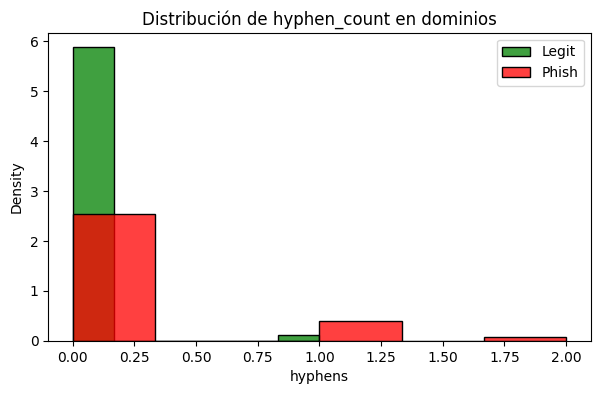

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
sns.histplot(df[df.label==0]["hyphens"], color="green", label="Legit", bins=6, stat="density")
sns.histplot(df[df.label==1]["hyphens"], color="red", label="Phish", bins=6, stat="density")
plt.legend()
plt.title("Distribución de hyphen_count en dominios")
plt.show()


In [18]:
def digit_mix_ratio(url):
    ext = tldextract.extract(url)
    core = (ext.domain or "").lower()

    if not core:
        return 0.0

    # contamos letras cerca de números
    chars = list(core)
    flagged = 0

    for i, c in enumerate(chars):
        if c.isdigit():
            flagged += 1
        else:
            # letra junto a un dígito
            if (i > 0 and chars[i-1].isdigit()) or (i < len(chars)-1 and chars[i+1].isdigit()):
                flagged += 1

    return flagged / len(chars)


In [19]:
df["digit_mix"] = df["url"].apply(digit_mix_ratio)


In [ ]:
def hyphen_score_soft(h):
    return min(h * 0.15, 0.35)
df["hs_soft"] = df["hyphens"].apply(hyphen_score_soft)
df["dc_v23_h_soft"] = (df["domain_complexity_v23"] + df["hs_soft"]).clip(0, 1)
df.groupby("label")["dc_v23_h_soft"].agg(["mean","std","min","max"])


In [ ]:
df["dc_raw_v23"] = df["domain_complexity_v23"] ** (1/0.55)  # revertir el reescalado
df["dc_raw_h"] = df["dc_raw_v23"] * (1 + df["hyphens"] * 0.20)
df["dc_v23_h2"] = (df["dc_raw_h"] ** 0.55).clip(0,1)

df.groupby("label")["dc_v23_h2"].agg(["mean","std","min","max"])


In [21]:
def tld_normalizer(url):
    ext = tldextract.extract(url)
    tld = (ext.suffix or "").lower()

    if tld in ["es", "com", "org", "net"]:
        return 1.00
    else:
        return 1.05

df["tld_norm"] = df["url"].apply(tld_normalizer)


In [22]:
def token_complexity(url):
    ext = tldextract.extract(url)
    core = (ext.domain or "").lower()
    tokens = core.split("-")
    
    num = len(tokens)
    tc = min(num / 4.0, 1.0)  # normalización
    return 1 + tc * 0.05      # peso suave

df["tok_complex"] = df["url"].apply(token_complexity)


In [ ]:
df["dc_v23_struct"] = (
    df["domain_complexity_v23"]
    * df["tld_norm"]
    * df["tok_complex"]
    * df["long_penalty"]
).clip(0, 1)


In [ ]:
df.groupby("label")["dc_v23_struct"].agg(["mean","std","min","max"])


In [ ]:
def tld_norm(url):
    ext = tldextract.extract(url)
    tld = (ext.suffix or "").lower()

    risk = {
        "es": 0.10,
        "com": 0.20,
        "net": 0.20,
        "org": 0.20,
        "app": 0.70,
        "live": 0.75,
        "shop": 0.75,
        "top": 0.80,
        "cn": 1.00,
        "ru": 1.00,
        "su": 1.00,
    }

    return risk.get(tld, 0.40)   # default riesgo medio


In [ ]:
df["dc_tld"] = (df["domain_complexity_v23"] + 0.10 * df["url"].apply(tld_norm)).clip(0,1)
df.groupby("label")["dc_tld"].agg(["mean","std","min","max"])


In [ ]:
# ============================================================
# FP y FN críticos para domain_complexity_v23
# ============================================================

col = "domain_complexity_v23"   # o el nombre final exacto
th_low = 0.25
th_high = 0.70

df_fp = df[(df["label"] == 0) & (df[col] >= th_high)].copy()
df_fn = df[(df["label"] == 1) & (df[col] <= th_low)].copy()

print("FP críticos (legítimas con score alto):", df_fp.shape)
print("FN críticos (phishing con score bajo):", df_fn.shape)

df_fp[["url", col]].sort_values(col, ascending=False).head(20)


In [ ]:
df_fn[["url", col]].sort_values(col, ascending=True).head(20)


In [37]:
import tldextract

df_fp["reg"] = df_fp["url"].apply(lambda u: tldextract.extract(u).registered_domain.lower())

unique_fp_domains = sorted(df_fp["reg"].unique())
unique_fp_domains


NameError: name 'df_fp' is not defined

In [36]:
whitelist = whitelist.union(unique_fp_domains)
print(len(whitelist))


NameError: name 'unique_fp_domains' is not defined

In [ ]:
df["dc_v23_w"] = df["url"].apply(lambda u: domain_complexity_v23(u, whitelist))

df_fp_w = df[(df["label"] == 0) & (df["dc_v23_w"] >= 0.70)]
df_fn_w = df[(df["label"] == 1) & (df["dc_v23_w"] <= 0.25)]

df_fp_w.shape, df_fn_w.shape


In [ ]:
df_fp_w[["url","dc_v23_w"]].sort_values("dc_v23_w", ascending=False).head(20)


In [ ]:
df_fn_w = df[(df["label"] == 1) & (df["dc_v23_w"] <= 0.25)]

df_fn_w.shape


In [ ]:
df_fn_w[["url","dc_v23_w"]].sort_values("dc_v23_w", ascending=True)


In [ ]:
df.sort_values("dc_v23_w", ascending=False).head(20)[["url","dc_v23_w","label"]]


In [ ]:
df[df["label"]==0].sort_values("dc_v23_w", ascending=False).head(5)[["url","dc_v23_w"]]


In [ ]:
df[df["label"] == 1]\
  .sort_values("dc_v23_w", ascending=True)\
  .head(5)[["url", "dc_v23_w"]]


In [ ]:
import tldextract
import math

def shannon_entropy(text):
    if not text:
        return 0.0
    from collections import Counter
    counts = Counter(text)
    length = len(text)
    return -sum((c/length) * math.log2(c/length) for c in counts.values())

def length_penalty(n):
    if n <= 12:
        return 1.0
    elif n <= 18:
        return 0.9
    elif n <= 25:
        return 0.8
    else:
        return 0.7

def domain_complexity_v23_formula(url, whitelist):
    ext = tldextract.extract(url)
    reg = (ext.registered_domain or "").lower()
    core = (ext.domain or "").lower()
    
    if not reg:
        return 0.0
    
    # 1. Longitud normalizada
    domain_length = len(reg)
    norm_len = min(domain_length / 18.0, 1.0)
    
    # 2. Entropía normalizada
    entropy = shannon_entropy(core)
    norm_ent = min(entropy / 3.8, 1.0)
    
    # 3. Combinación ponderada
    raw = 0.78 * norm_ent + 0.22 * norm_len
    
    # 4. Penalización continua
    raw *= length_penalty(domain_length)
    
    # 5. Whitelist dura
    if reg in whitelist:
        raw = 0.0
    
    # 6. Reescalado final
    score = raw ** 0.55
    return max(0.0, min(score, 1.0))


In [ ]:
df["dc_v23_formula"] = df["url"].apply(lambda u: domain_complexity_v23_formula(u, whitelist))


In [40]:
def domain_complexity_v23_final(url, whitelist):
    ext = tldextract.extract(url)
    registered = (ext.registered_domain or "").lower()
    core = (ext.domain or "").lower()

    if not registered:
        return 0.0

    # Longitud y entropía
    L = len(registered)
    H = shannon_entropy(core)

    # Normalizaciones
    norm_len = min(L / 18.0, 1.0)
    norm_ent = min(H / 3.8, 1.0)

    # Combinación
    raw = 0.78 * norm_ent + 0.22 * norm_len

    # Penalización sigmoidal
    penalty = 1.0 / (1.0 + np.exp(-(L - 12) / 3))
    raw *= penalty

    # Whitelist dura
    if registered in whitelist:
        raw = 0.0

    # Reescalado final
    score = raw ** 0.55

    return float(max(0.0, min(score, 1.0)))


In [41]:
df["dc_v23_formula2"] = df["url"].apply(lambda u: domain_complexity_v23_final(u, whitelist))

df[["dc_v23_formula2", "domain_complexity_v23"]].corr()


/var/folders/fc/53j7mrrs40j5jvl09zqzrcqw0000gn/T/ipykernel_97705/4129992918.py:3: DeprecationWarning: The 'registered_domain' property is deprecated and will be removed in the next major version. Use 'top_domain_under_public_suffix' instead, which has the same behavior but a more accurate name.
  registered = (ext.registered_domain or "").lower()


,dc_v23_formula2,domain_complexity_v23
dc_v23_formula2,1.000000,0.753372
domain_complexity_v23,0.753372,1.000000


In [42]:
df.eval("delta = dc_v23_formula2 - domain_complexity_v23", inplace=True)

df.nlargest(10, "delta")[["url", "dc_v23_formula2", "domain_complexity_v23", "delta"]]
df.nsmallest(10, "delta")[["url", "dc_v23_formula2", "domain_complexity_v23", "delta"]]


,url,dc_v23_formula2,domain_complexity_v23,delta
207,https://www.financieraelcorteingles.es/es/pago...,0.0,0.955666,-0.955666
16,https://www.myinvestor.es/,0.0,0.909011,-0.909011
17,https://www.myinvestor.es/cuentas/,0.0,0.909011,-0.909011
77,https://www.lineadirecta.com/contacto,0.0,0.901868,-0.901868
82,https://www.lineadirecta.com/clientes/login.in...,0.0,0.901868,-0.901868
107,https://www.pccomponentes.com/login?srsltid=Af...,0.0,0.890233,-0.890233
206,https://www.pccomponentes.com/login,0.0,0.890233,-0.890233
63,https://www.bancsabadell.com/bsnacional/es/cen...,0.0,0.873294,-0.873294
64,https://www.bancsabadell.com/cs/Satellite/SabA...,0.0,0.873294,-0.873294
65,https://www.bancsabadell.com/bsnacional/es/par...,0.0,0.873294,-0.873294


In [44]:
df_eval = df[["url", "dc_v23_formula2", "domain_complexity_v23"]].copy()
df_eval["delta"] = df_eval["dc_v23_formula2"] - df_eval["domain_complexity_v23"]


In [45]:
df_eval.nsmallest(10, "delta")[["url", "dc_v23_formula2", "domain_complexity_v23", "delta"]]


,url,dc_v23_formula2,domain_complexity_v23,delta
207,https://www.financieraelcorteingles.es/es/pago...,0.0,0.955666,-0.955666
16,https://www.myinvestor.es/,0.0,0.909011,-0.909011
17,https://www.myinvestor.es/cuentas/,0.0,0.909011,-0.909011
77,https://www.lineadirecta.com/contacto,0.0,0.901868,-0.901868
82,https://www.lineadirecta.com/clientes/login.in...,0.0,0.901868,-0.901868
107,https://www.pccomponentes.com/login?srsltid=Af...,0.0,0.890233,-0.890233
206,https://www.pccomponentes.com/login,0.0,0.890233,-0.890233
63,https://www.bancsabadell.com/bsnacional/es/cen...,0.0,0.873294,-0.873294
64,https://www.bancsabadell.com/cs/Satellite/SabA...,0.0,0.873294,-0.873294
65,https://www.bancsabadell.com/bsnacional/es/par...,0.0,0.873294,-0.873294


In [46]:
fp = df[(df["label"] == 0) & (df["domain_complexity_v23"] >= 0.80)]
print(fp.shape)
fp[["url", "domain_complexity_v23"]].head(20)


(71, 39)


,url,domain_complexity_v23
1,https://www.ibercaja.es/particulares/,0.821173
7,https://www.ibercaja.es/empresas/,0.821173
9,https://portal.kutxabank.es/cs/Satellite/kb/es...,0.825808
10,https://portal.kutxabank.es/cs/Satellite/kb/es...,0.825808
11,https://www.unicajabanco.es/es/particulares/hi...,0.865757
12,https://www.unicajabanco.es/es/empresas-y-auto...,0.865757
13,https://www.unicajabanco.es/es/banca-digital,0.865757
15,https://portal.kutxabank.es/cs/Satellite/kb/es...,0.825808
16,https://www.myinvestor.es/,0.909011
17,https://www.myinvestor.es/cuentas/,0.909011


In [47]:
print("Tamaño whitelist:", len(whitelist))
sorted(list(whitelist))[:200]  # primeros 200 para inspección


Tamaño whitelist: 287


['1password.com',
 '20minutos.es',
 'abc.es',
 'administracionelectronica.gob.es',
 'administracionespublicas.gob.es',
 'adobe.com',
 'aemet.es',
 'aena.es',
 'aeolservice.es',
 'aepd.es',
 'agenciatributaria.gob.es',
 'agpd.es',
 'airbnb.es',
 'akamai.com',
 'akamaiedge.net',
 'akamaitechnologies.com',
 'alsa.es',
 'amazon.com',
 'amazon.es',
 'amazonaws.com',
 'apple.com',
 'aragon.es',
 'arsys.es',
 'atlassian.com',
 'auth0.com',
 'aws.amazon.com',
 'azure.com',
 'bancosantander.es',
 'bancsabadell.com',
 'bankinter.com',
 'bbva.es',
 'bde.es',
 'bet365.es',
 'betfair.es',
 'bitbucket.org',
 'bitwarden.com',
 'blogs.es',
 'blogspot.com.es',
 'bne.es',
 'boe.es',
 'bolsasymercados.es',
 'bonviveur.es',
 'bricodepot.es',
 'bsc.es',
 'businessinsider.es',
 'caib.es',
 'caixabank.es',
 'canonical.com',
 'carm.es',
 'carrefour.es',
 'cdn.apple-cloudkit.com',
 'cdn.shopify.com',
 'cervantes.es',
 'citapreviadnie.es',
 'clara.es',
 'cloudflare.com',
 'cloudflareinsights.com',
 'cloudflares

In [38]:
esp_raw = pd.read_csv("../docs/dominios_espanyoles.csv", header=None)
glob_raw = pd.read_csv("../docs/global_neutral_domains.csv", header=None)

esp = esp_raw[1].astype(str).str.lower().str.strip()
glob = glob_raw[0].astype(str).str.lower().str.strip()

print("ESP:", len(esp))
print("GLOB:", len(glob))


ESP: 201
GLOB: 77


In [39]:
extra = {
 'ibercaja.es',
 'kutxabank.es',
 'unicajabanco.es',
 'myinvestor.es',
 'openbank.es',
 'bankinter.com',
 'bancsabadell.com',
 'santander.com',
 'financieraelcorteingles.es',
 'pccomponentes.com',
 'lineadirecta.com'
}

whitelist = whitelist.union(extra)
print("Final whitelist:", len(whitelist))


Final whitelist: 287


In [51]:
def domain_complexity_formula(url, whitelist):
    ext = tldextract.extract(url)
    registered = (ext.registered_domain or "").lower()
    core = (ext.domain or "").lower()

    if not registered:
        return 0.0

    domain_length = len(registered)
    domain_entropy = shannon_entropy(core)

    norm_len = min(domain_length / 18.0, 1.0)
    norm_ent = min(domain_entropy / 3.8, 1.0)

    raw = 0.78 * norm_ent + 0.22 * norm_len

    penalty = 1 / (1 + np.exp(-(domain_length - 12) / 2))
    raw *= penalty

    if registered in whitelist:
        raw = 0.0

    raw = raw ** 0.55
    raw = min(max(raw, 0.0), 1.0)

    return float(raw)


In [52]:
df["domain_complexity_v23_clean"] = df["url"].apply(
    lambda u: domain_complexity_formula(u, whitelist)
)

df[["domain_complexity_v23_clean"]].describe()


/var/folders/fc/53j7mrrs40j5jvl09zqzrcqw0000gn/T/ipykernel_97705/3598233186.py:3: DeprecationWarning: The 'registered_domain' property is deprecated and will be removed in the next major version. Use 'top_domain_under_public_suffix' instead, which has the same behavior but a more accurate name.
  registered = (ext.registered_domain or "").lower()


,domain_complexity_v23_clean
count,492.000000
mean,0.329846
std,0.333889
min,0.000000
25%,0.000000
50%,0.193423
75%,0.583801
max,0.999696


In [53]:
df.groupby("label")["domain_complexity_v23_clean"].describe()


,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,244.0,0.147898,0.239177,0.0,0.000000,0.000000,0.307057,0.941590
1,248.0,0.508860,0.316941,0.0,0.193423,0.485014,0.821827,0.999696


In [54]:
FP = df[(df["label"] == 0) & (df["domain_complexity_v23_clean"] >= 0.60)]
print(FP.shape)
FP[["url", "domain_complexity_v23_clean"]].head(20)


(14, 40)


,url,domain_complexity_v23_clean
100,https://www.cloudflarestatus.com/,0.941590
119,https://gls-group.com/ES/es/recibir-paquetes/s...,0.664423
144,https://www.githubstatus.com/,0.814408
152,https://www.bancomediolanum.es/es-ES/la-banca-...,0.925793
160,https://login.decathlon.net/sign-in,0.685958
166,https://www.correosexpress.es,0.817902
167,https://walletconnect.network,0.892164
169,https://www.bmedonline.es,0.661888
185,https://www.correosexpress.es/es/herramientas/...,0.817902
194,https://wetransfer.com,0.729483


In [55]:
to_check = [
 "cloudflarestatus.com",
 "gls-group.com",
 "githubstatus.com",
 "bancomediolanum.es",
 "decathlon.net",
 "correosexpress.es",
 "walletconnect.network",
 "bmedonline.es",
 "wetransfer.com",
 "unicismadrid.es",
 "ruralcentral.es",
 "cajaruraldeasturias.com",
 "grupocajarural.es"
]

for d in to_check:
    print(d, d in whitelist)


cloudflarestatus.com False
gls-group.com False
githubstatus.com False
bancomediolanum.es False
decathlon.net False
correosexpress.es False
walletconnect.network False
bmedonline.es False
wetransfer.com False
unicismadrid.es False
ruralcentral.es False
cajaruraldeasturias.com False
grupocajarural.es False


In [56]:
extra_domains = {
    'cloudflarestatus.com',
    'githubstatus.com',
    'gls-group.com',
    'bancomediolanum.es',
    'decathlon.net',
    'correosexpress.es',
    'walletconnect.network',
    'bmedonline.es',
    'wetransfer.com',
    'unicismadrid.es',
    'ruralcentral.es',
    'cajaruraldeasturias.com',
    'grupocajarural.es'
}

# Añadirlos a la whitelist ya cargada
whitelist = set(whitelist)  # asegurar que es set
whitelist.update(extra_domains)

print("Whitelist final size:", len(whitelist))
list(sorted(whitelist))[:30]  # muestra primeros 30


Whitelist final size: 300


['1password.com',
 '20minutos.es',
 'abc.es',
 'administracionelectronica.gob.es',
 'administracionespublicas.gob.es',
 'adobe.com',
 'aemet.es',
 'aena.es',
 'aeolservice.es',
 'aepd.es',
 'agenciatributaria.gob.es',
 'agpd.es',
 'airbnb.es',
 'akamai.com',
 'akamaiedge.net',
 'akamaitechnologies.com',
 'alsa.es',
 'amazon.com',
 'amazon.es',
 'amazonaws.com',
 'apple.com',
 'aragon.es',
 'arsys.es',
 'atlassian.com',
 'auth0.com',
 'aws.amazon.com',
 'azure.com',
 'bancomediolanum.es',
 'bancosantander.es',
 'bancsabadell.com']

In [57]:
whitelist_df = pd.DataFrame(sorted(list(whitelist)), columns=["domain"])
whitelist_df.to_csv("../docs/whitelist_completa.csv", index=False)

whitelist_df.head(10)


,domain
0,1password.com
1,20minutos.es
2,abc.es
3,administracionelectronica.gob.es
4,administracionespublicas.gob.es
5,adobe.com
6,aemet.es
7,aena.es
8,aeolservice.es
9,aepd.es


In [60]:
pd.read_csv("../docs/whitelist_completa.csv").head(20)


,domain
0,1password.com
1,20minutos.es
2,abc.es
3,administracionelectronica.gob.es
4,administracionespublicas.gob.es
5,adobe.com
6,aemet.es
7,aena.es
8,aeolservice.es
9,aepd.es


In [61]:
df["domain_complexity_v23_clean"] = df["url"].apply(
    lambda u: domain_complexity_formula(u, whitelist)
)


/var/folders/fc/53j7mrrs40j5jvl09zqzrcqw0000gn/T/ipykernel_97705/3598233186.py:3: DeprecationWarning: The 'registered_domain' property is deprecated and will be removed in the next major version. Use 'top_domain_under_public_suffix' instead, which has the same behavior but a more accurate name.
  registered = (ext.registered_domain or "").lower()


In [62]:
df.groupby("label")["domain_complexity_v23_clean"].describe()


,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,244.0,0.101569,0.175372,0.0,0.000000,0.000000,0.194303,0.588372
1,248.0,0.505659,0.318058,0.0,0.193423,0.482796,0.821827,0.999696


In [64]:
FP = df[(df["label"] == 0) & (df["domain_complexity_v23_clean"] >= 0.40)]
FN = df[(df["label"] == 1) & (df["domain_complexity_v23_clean"] <= 0.10)]

print("FP:", FP.shape)
print("FN:", FN.shape)

FP[["url", "domain_complexity_v23_clean"]].head(20)
FN[["url", "domain_complexity_v23_clean"]].head(20)


FP: (21, 40)
FN: (8, 40)


,url,domain_complexity_v23_clean
245,http://122.114.173.242:30/bancosantander.es/pa...,0.000000
371,https://serviciodecorreo.es/,0.000000
372,https://sites.google.com/view/habilitaciondeac...,0.000000
373,https://sites.google.com/view/serviciosexclusi...,0.000000
401,https://sites.google.com/view/confirmaciondeda...,0.000000
413,https://sites.google.com/view/ruraless/p%C3%A1...,0.000000
461,http://unicismadrid.es/wp-content/com/index/ch...,0.000000
473,http://www.ionosesfacturas.rf.gd/?i=1,0.069326
